# Importation des modules

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from skimage import data

from PIL.Image import *

from imageio import imread
import glob
from tqdm import tnrange
from tqdm.notebook import tqdm_notebook
import tqdm
import torch
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torchvision.utils import save_image

import multiprocessing



In [2]:
torch.cuda.is_available()

True

# Test de modèle


## Chargement du dataset

In [10]:
size = 120
deep = 3

In [4]:
def image_to_numpy(image) :
    n = len(image)
    image_bis = []
    for i in range (n) :
        image_bis.append([])
        for j in range(n) :
            image_bis[i].append(image[i][j][0])
    return np.array(image_bis)

In [5]:
list_images = []
list_labels = []

list_path = set()

path_imgs = "trans/"

def select_unique_imgs():
    for image_path in tqdm_notebook(glob.glob(path_imgs + "*.png")):
        label = image_path.find('l')
        couche = image_path.find('c')
        id_image = image_path[:couche]
        label_image = int(image_path[label+1:couche])
        list_path.add((id_image, label_image))



def load_pictures(data_files):
    with multiprocessing.Pool() as p :
        res = list(tqdm.tqdm(p.imap(load_image3.load_img_from_path, data_files), total=len(data_files)))
    for lot_lab, lot_img in tqdm.tqdm(res, total=len(res)):
        list_images.append(lot_img)
        list_labels.append(lot_lab)

In [6]:
select_unique_imgs()

In [7]:
import load_image3


if __name__ ==  '__main__' : 
    load_pictures(list_path)

100%|█████████████████████████████████████████████████████████████████████████| 3106/3106 [00:00<00:00, 1034832.65it/s]


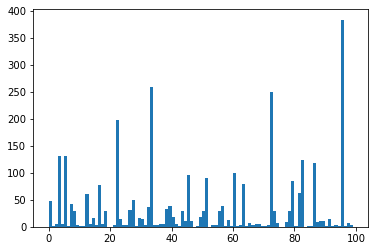

In [8]:
n = len(list_images)
num_label = plt.hist(list_labels, bins=range(max(list_labels)+2))

In [9]:
num_label = num_label[0]
deep=3

In [10]:
nouv_label = [-1]*(max(list_labels)+2)
compteur = 0
for i in range(max(list_labels)+1) :
    if num_label[i]>0 :
        nouv_label[i]=compteur
        compteur+=1

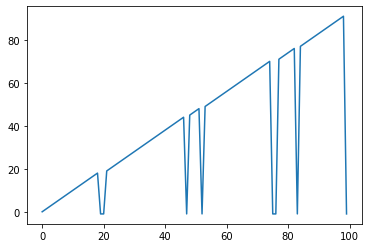

In [11]:
plt.plot(nouv_label)

In [12]:
label_max = max(nouv_label)
print(label_max)

91


In [13]:
nouv_list_labels = []
for i in range(len(list_labels)) :
    nouv_list_labels.append(nouv_label[list_labels[i]])

(array([ 48.,   1.,   5., 132.,   6., 132.,   2.,  42.,  30.,   3.,   2.,
          2.,  60.,   5.,  17.,   4.,  77.,   5.,  30.,   4., 198.,  14.,
          3.,   4.,  31.,  50.,   1.,  16.,  15.,   4.,  36., 260.,   4.,
          3.,   5.,   6.,  33.,  38.,  18.,   6.,   2.,  30.,  10.,  96.,
         10.,   2.,  19.,  29.,  91.,   4.,   4.,  29.,  39.,   1.,  12.,
          1.,  99.,   2.,   3.,  80.,   1.,   7.,   3.,   5.,   5.,   1.,
          1.,   4., 250.,  29.,   7.,   9.,  29.,  85.,   2.,  62., 123.,
          2.,   2., 118.,   8.,  11.,  10.,   1.,  15.,   1.,   3.,   2.,
        384.,   1.,   7.,   3.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83

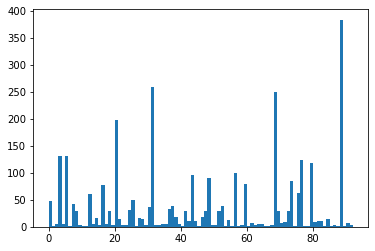

In [14]:
plt.hist(nouv_list_labels, bins=range(label_max +2))

In [15]:
num_classes = label_max+1
num_classes

92

In [16]:
def shuffle_in_unison(list_images, list_labels):
    assert len(list_images) == len(list_labels)
    shuffled_list_images = np.empty(list_images.shape, dtype=list_images.dtype)
    shuffled_list_labels = np.empty(list_labels.shape, dtype=list_labels.dtype)
    permutation = np.random.permutation(len(list_images))
    for old_index, new_index in enumerate(permutation):
        shuffled_list_images[new_index] = list_images[old_index]
        shuffled_list_labels[new_index] = list_labels[old_index]
    return shuffled_list_images, shuffled_list_labels

In [17]:
len(list_images[3])

3

In [18]:
def list_to_torch(list_images, list_labels) :
    n = len(list_images)
    
    torch_images=np.array([np.asarray(data) for data in list_images])
    torch_labels=np.array(list_labels)
    
    torch_images, torch_labels=shuffle_in_unison(torch_images, torch_labels)
    
    torch_images = torch.from_numpy(torch_images).cuda()
    torch_labels = torch.from_numpy(torch_labels).cuda()
    
    train_set = torch.utils.data.TensorDataset(torch_images[:int(0.8*n)],torch_labels[:int(0.8*n)])
    test_set = torch.utils.data.TensorDataset(torch_images[int(0.8*n):],torch_labels[int(0.8*n):])
    
    return train_set, test_set

In [19]:
train_set, test_set = list_to_torch(list_images, nouv_list_labels)

In [20]:
def train_epoch(net, train_set, opt, criterion, batch_size):
    net.train()
    trainloader = torch.utils.data.DataLoader(train_set, batch_size)
    for x_batch, y_batch in trainloader :
        opt.zero_grad()
        # Forward
        y_pred = net(x_batch.float())
        y_batch = y_batch.long()
        # Compute diff
        loss = criterion(y_pred, y_batch)
        # Compute gradients
        loss.backward()
        # update weights
        opt.step()

def accuracy(net, dataset):
    net.eval()
    correct = 0
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=1)
    for x_batch, y_batch in trainloader :
        y_pred = net(x_batch.float())
        y_pred = torch.argmax(y_pred).int()
        if int(y_pred)==int(y_batch[0]) :
            correct+=1
    return correct/len(dataset)

In [5]:
model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth', # bn: batch normalization
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth'
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
  layers = []
  prec_deep = 3
  for truc in cfg :
    if truc=='M' :
      layers.append(nn.MaxPool2d(2,None,0))
    else :
      layers.append(nn.Conv2d(prec_deep,truc,3,1,1))
      if batch_norm :
        layers.append(nn.BatchNorm2d(truc))
      layers.append(nn.ReLU(inplace=True))
      prec_deep = truc
  return nn.Sequential(*layers)



cfg = { # M stands for max pooling 
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [6]:
def vgg_11_classifier(num_classes):
  classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )
  return classifier
  
def vgg11_bn(num_classes, pretrained=False, letter='A', **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg[letter], batch_norm=True), **kwargs) # change cfg version for bonus
    if pretrained:
      if letter == 'A' :
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn'])) # change model url for bn
      elif letter == 'E' :
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19_bn']))
      else :
        print("Lettre non prise en charge")
    model.classifier = vgg_11_classifier(num_classes)
    return model

In [ ]:
epochs = 20
criterion = nn.CrossEntropyLoss()

net = vgg11_bn(num_classes=num_classes, pretrained=True).cuda()


opt = torch.optim.Adam(net.parameters(),lr=1e-3,betas=(0.9, 0.999),eps=1e-08)

compteur = 0

preci_train = []
preci_test = []

for i in tnrange(epochs) :
    train_epoch(net, train_set, opt, criterion, batch_size=2)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label = "test")
plt.legend()
plt.show()

print("accuracy :") 
accuracy(net, test_set)

C:\Users\stani\anaconda3\envs\modal\lib\site-packages\ipykernel_launcher.py:14: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


In [ ]:
for i in tnrange(epochs) :
    train_epoch(net, train_set, opt, criterion, batch_size=2)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label = "test")
plt.legend()
plt.show()

print("accuracy :") 
accuracy(net, test_set)


In [ ]:
for i in tnrange(epochs) :
    train_epoch(net, train_set, opt, criterion, batch_size=2)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label = "test")
plt.legend()
plt.show()

print("accuracy :") 
accuracy(net, test_set)

In [4]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()

        #first scale :
        self.first_scale = nn.Conv2d(in_planes, kernel_1_x, kernel_size=1, padding=0)

        #second scale :
        second_scale_1 = nn.Conv2d(in_planes, kernel_3_in, kernel_size=1, padding=0)
        second_scale_2 = nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1)

        self.second_scale = nn.Sequential(second_scale_1,second_scale_2)

        #third scale :
        third_scale_1 = nn.Conv2d(in_planes, kernel_5_in, kernel_size=1, padding=0)
        third_scale_2 = nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=5, padding=2)

        self.third_scale = nn.Sequential(third_scale_1,third_scale_2)


        #forth scale :
        forth_scale_1 = nn.MaxPool2d(3,1, padding=1)
        forth_scale_2 = nn.Conv2d(in_planes, pool_planes, kernel_size=1, padding=0)   
        
        self.forth_scale = nn.Sequential(forth_scale_1,forth_scale_2)


    def forward(self, x):
      
      x1 = self.first_scale(x)
      x2 = self.second_scale(x)
      x3 = self.third_scale(x)
      x4 = self.forth_scale(x)
        
      res = torch.cat([x1,x2,x3,x4],1)
      return res


class GoogLeNet(nn.Module):
    def __init__(self, input_dim=9):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(input_dim, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        
        self.layer1 = Inception(192,  64,  96, 128, 16, 32, 32)
        
        self.layer2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.layer3 = Inception(480, 192,  96, 208, 16,  48,  64)
        
        #classifier
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.avgpool = nn.AvgPool2d(15, stride=1)
        self.linear = nn.Linear(512, num_classes)
        

    def forward(self, x):
        
        x = self.pre_layers(x)
        x = self.layer1(x)
        x = self.max_pool(x)
        x = self.layer2(x)
        x = self.max_pool(x)
        x = self.layer3(x)
        x = self.max_pool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


In [ ]:
epochs = 20
criterion = nn.CrossEntropyLoss()

net =  GoogLeNet(deep).cuda()

opt = torch.optim.Adam(net.parameters(),lr=1e-3,betas=(0.9, 0.999),eps=1e-08)

compteur = 0

preci_train = []
preci_test = []

for i in tnrange(epochs) :
    train_epoch(net, train_set, opt, criterion, batch_size=10)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label = "test")
plt.legend()
plt.show()

print("accuracy :") 
accuracy(net, test_set)

In [58]:
num_classes = 655

# warning deep

In [68]:
ggnet_trained = GoogLeNet(9).cuda()
ggnet_trained.load_state_dict(torch.load("poids_models/ggnet_sup150_60.ckpt"))

<All keys matched successfully>

In [69]:
ggnet = GoogLeNet(9).cuda()

In [71]:
for param, trained_param in zip(ggnet.parameters(), ggnet_trained.parameters()):
    print("pas entrainé")
    print(param)
    print("entrainé")
    print(trained_param)

pas entrainé
Parameter containing:
tensor([[[[ 0.0114,  0.0305, -0.0331],
          [ 0.0149,  0.0344, -0.0277],
          [ 0.0023,  0.0274,  0.0861]],

         [[-0.0547, -0.0282,  0.0904],
          [ 0.0884,  0.0926, -0.1020],
          [-0.1046,  0.0622, -0.1033]],

         [[ 0.0642,  0.0277,  0.0143],
          [ 0.0068, -0.1002,  0.0112],
          [ 0.0671,  0.0460,  0.0633]],

         ...,

         [[ 0.0160, -0.0197,  0.0697],
          [ 0.0637, -0.0733, -0.0642],
          [-0.0310,  0.0371, -0.0896]],

         [[-0.0768,  0.0442, -0.0556],
          [-0.0689,  0.0938, -0.0410],
          [ 0.0913,  0.0471,  0.0564]],

         [[ 0.0269, -0.1071, -0.0562],
          [ 0.0096,  0.0558,  0.0979],
          [ 0.0516, -0.0271,  0.0924]]],


        [[[ 0.0071, -0.0716, -0.0631],
          [ 0.0759, -0.0011,  0.0387],
          [-0.0126, -0.0038,  0.0302]],

         [[-0.0749,  0.0559, -0.0123],
          [-0.1047,  0.0157,  0.0882],
          [ 0.0395, -0.0627,  0.0748]

       device='cuda:0', requires_grad=True)
pas entrainé
Parameter containing:
tensor([[[[ 0.0523]],

         [[ 0.0121]],

         [[ 0.0008]],

         ...,

         [[ 0.0536]],

         [[ 0.0264]],

         [[-0.0037]]],


        [[[-0.0005]],

         [[-0.0368]],

         [[-0.0344]],

         ...,

         [[ 0.0436]],

         [[-0.0417]],

         [[-0.0574]]],


        [[[ 0.0135]],

         [[ 0.0539]],

         [[ 0.0702]],

         ...,

         [[-0.0405]],

         [[-0.0672]],

         [[ 0.0620]]],


        ...,


        [[[-0.0287]],

         [[-0.0255]],

         [[-0.0457]],

         ...,

         [[-0.0480]],

         [[-0.0654]],

         [[ 0.0317]]],


        [[[-0.0544]],

         [[ 0.0647]],

         [[ 0.0674]],

         ...,

         [[ 0.0469]],

         [[-0.0109]],

         [[-0.0452]]],


        [[[ 0.0513]],

         [[ 0.0124]],

         [[-0.0545]],

         ...,

         [[ 0.0404]],

         [[-0.0462]],

 

Parameter containing:
tensor([[[[-9.4202e-03,  1.0499e-02, -8.8311e-03, -1.7506e-02, -1.5258e-02],
          [ 1.6201e-02,  1.9239e-02, -1.3487e-02,  3.5906e-02, -3.5971e-02],
          [-4.7143e-02,  4.0633e-02,  2.1133e-02,  3.0405e-02,  3.6716e-02],
          [-1.7459e-02, -3.2503e-02,  1.9219e-02,  3.4951e-02, -4.1760e-02],
          [ 1.8473e-02, -7.8973e-03,  2.5646e-02, -1.8427e-02,  4.2454e-03]],

         [[-1.2711e-02,  2.8237e-02, -2.9105e-02, -3.6620e-02,  1.6015e-03],
          [-1.4988e-02,  3.5579e-02, -1.6100e-02,  2.9601e-02,  1.8518e-02],
          [ 3.4277e-02,  1.3624e-02,  2.5909e-03, -6.6640e-03,  6.1696e-03],
          [ 1.5823e-02,  2.9487e-02, -3.7303e-02,  1.6823e-02,  4.3709e-02],
          [-2.3104e-03, -3.0541e-02,  1.9309e-02,  2.3565e-02, -4.7922e-02]],

         [[-1.5328e-02,  2.1647e-02, -4.8762e-02,  4.1286e-02,  2.1659e-02],
          [ 2.1087e-02, -3.9317e-02,  4.0531e-02,  3.8360e-02,  1.5468e-02],
          [ 3.7266e-02, -2.6555e-02, -3.8335e-02, 

       requires_grad=True)
entrainé
Parameter containing:
tensor([ 4.0075e-03, -1.5420e-03,  2.5116e-03, -7.3213e-03, -3.8544e-03,
         1.2129e-03,  1.6625e-03, -1.1278e-03, -3.1013e-03,  8.9662e-04,
         1.7128e-03,  2.9925e-03,  2.4172e-05,  1.6451e-03, -6.6835e-04,
        -1.3666e-03, -7.3562e-03,  7.5078e-04, -3.7665e-03,  6.4179e-03,
        -7.5995e-04, -2.5825e-03,  2.8946e-03, -1.8300e-03,  4.2151e-03,
        -5.5166e-05, -3.5895e-03,  9.4591e-04,  4.1414e-04,  2.1790e-04,
         4.6801e-03,  3.2635e-03,  1.6063e-03,  1.5793e-03,  1.3736e-04,
         5.3403e-04,  4.2779e-03, -4.1750e-03,  3.5254e-03, -4.9686e-03,
         8.5915e-03, -3.4066e-03, -2.0894e-04,  2.4069e-04,  4.0240e-03,
        -2.1005e-03,  9.7628e-04, -1.0369e-02,  8.9923e-04,  2.5851e-03,
         1.7210e-03, -7.1997e-03, -1.7120e-03,  5.3179e-03,  2.0509e-04,
        -3.5907e-03, -5.3223e-03,  4.2419e-03, -5.1030e-03, -3.0455e-03,
        -2.7016e-03, -5.5393e-03, -5.3088e-03, -1.2172e-03,  2.682

       device='cuda:0', requires_grad=True)
entrainé
Parameter containing:
tensor([[[[-1.8127e-01, -4.6323e-01,  2.4278e-01,  2.2876e-02, -8.9764e-02],
          [-1.7803e-01, -6.2707e-02,  3.5884e-01,  1.1708e-01, -2.2637e-01],
          [ 1.8749e-01,  5.0540e-02,  4.4839e-01,  3.8669e-02,  5.1058e-02],
          [ 1.4480e-02, -2.1786e-01, -2.2716e-02, -5.8648e-02,  1.9787e-01],
          [-1.0065e-01,  2.0132e-01, -1.6648e-01, -1.3373e-01,  8.9368e-02]],

         [[ 1.8113e-01, -9.2214e-02,  3.2198e-01,  2.7897e-01,  2.2003e-01],
          [ 1.6248e-01, -1.3796e-01,  2.2489e-02, -6.5679e-02,  8.0419e-02],
          [-5.5559e-01, -4.2098e-01, -3.4258e-01, -2.5372e-01, -1.7190e-02],
          [-1.0040e-01,  5.4505e-02,  9.3199e-02,  1.3040e-01,  8.0720e-02],
          [ 2.6988e-02, -2.8269e-01,  1.7288e-01, -3.4092e-01,  2.8010e-01]],

         [[ 7.0281e-01,  3.2285e-01, -2.8869e-02, -3.2814e-02,  3.1340e-01],
          [ 3.2785e-01, -2.2892e-01, -1.9860e-01, -2.8210e-01,  3.0241e-01

entrainé
Parameter containing:
tensor([-0.4912, -0.7495, -0.7013, -0.4271, -0.6622, -0.6103, -0.4674, -0.6258,
        -0.7410, -0.2885, -0.1788, -0.7537, -0.5948, -0.2753, -0.8225, -0.8921,
        -1.1641, -0.4187, -0.3206, -0.9106, -0.6572, -0.6424, -0.5982, -0.5018,
        -0.4795, -0.4471, -0.8694, -0.5653, -0.7360, -0.7509, -0.8570, -0.5578,
        -0.8170, -0.7090, -0.9183, -0.7251, -0.9563, -0.4478, -0.4700, -0.8260,
        -0.4172, -0.7055, -0.6612, -0.3848, -0.5713, -0.7602, -0.3470, -0.4201,
        -0.6863, -0.5808, -0.6468, -0.8127, -0.6315, -0.3518, -0.8022, -0.5173,
        -0.6902, -0.7039, -0.6058, -0.5388, -0.5922, -0.3145, -0.7649, -0.5151,
        -0.7439, -0.5785, -0.7187, -0.6661, -0.3344, -0.2859, -0.3355, -0.6338,
        -0.4190, -0.4813, -0.6567, -0.6302, -0.8064, -0.7757, -0.6303, -0.4973,
        -0.6284, -0.8175, -0.7703, -0.6720, -0.7995, -0.3289, -0.9944, -0.4461,
        -0.5993, -0.7660, -0.2926, -0.3553, -0.7344, -0.8064, -0.3671, -0.4706,
        -

       device='cuda:0', requires_grad=True)
pas entrainé
Parameter containing:
tensor([[[[-3.8410e-02, -8.0802e-03,  3.1785e-02, -1.0397e-02,  4.9283e-02],
          [-2.8881e-02,  4.0084e-02, -1.8256e-02, -4.7267e-02,  3.0433e-02],
          [ 4.0083e-02, -8.8181e-03,  1.9044e-02, -2.5186e-02,  1.1238e-02],
          [ 8.6214e-03,  2.2904e-03,  2.4747e-02, -2.8725e-02,  2.4822e-03],
          [-3.0984e-02, -3.0505e-02,  3.7688e-02,  4.1216e-02,  2.2368e-02]],

         [[ 1.2475e-02,  1.4061e-02, -4.6210e-02,  4.2665e-02,  3.0505e-02],
          [ 4.2249e-05,  3.7929e-02,  4.8386e-02,  3.2553e-02, -4.4988e-02],
          [ 4.7261e-02, -1.0267e-03, -2.5228e-03, -1.6152e-02, -2.2806e-02],
          [-2.2286e-02,  3.2667e-02,  3.4284e-02,  2.6861e-02, -8.6444e-03],
          [ 8.8950e-03,  1.1071e-02,  4.0116e-02, -1.1463e-02, -4.7654e-02]],

         [[ 4.7127e-03,  5.0099e-03,  2.5698e-03,  1.8921e-02, -4.6246e-02],
          [ 1.7752e-02,  2.0111e-02,  2.0675e-02, -3.6852e-02,  2.5673

       device='cuda:0', requires_grad=True)
pas entrainé
Parameter containing:
tensor([[[[-0.0334]],

         [[ 0.0302]],

         [[ 0.0396]],

         ...,

         [[ 0.0112]],

         [[-0.0260]],

         [[ 0.0354]]],


        [[[ 0.0411]],

         [[ 0.0397]],

         [[-0.0055]],

         ...,

         [[ 0.0229]],

         [[-0.0386]],

         [[ 0.0293]]],


        [[[-0.0278]],

         [[-0.0395]],

         [[-0.0393]],

         ...,

         [[-0.0017]],

         [[-0.0250]],

         [[ 0.0309]]],


        ...,


        [[[ 0.0056]],

         [[ 0.0383]],

         [[ 0.0383]],

         ...,

         [[ 0.0391]],

         [[-0.0127]],

         [[ 0.0163]]],


        [[[-0.0409]],

         [[-0.0394]],

         [[ 0.0402]],

         ...,

         [[-0.0015]],

         [[ 0.0117]],

         [[ 0.0101]]],


        [[[ 0.0148]],

         [[-0.0279]],

         [[ 0.0368]],

         ...,

         [[-0.0253]],

         [[ 0.0409]],

 

In [73]:
params_trained = ggnet_trained.named_parameters()
params = ggnet.named_parameters()

dict_params_trained = dict(params_trained)
dict_params = dict(params)


compteur = 0
for name in dict_params :
    if compteur<40 :
        dict_params[name].data.copy_(dict_params_trained[name])
        compteur+=1

In [74]:
for param, trained_param in zip(ggnet.parameters(), ggnet_trained.parameters()):
    print("pas entrainé")
    print(param)
    print("entrainé")
    print(trained_param)

pas entrainé
Parameter containing:
tensor([[[[ 0.0574,  0.0780, -0.0221],
          [ 0.4944,  0.4160, -0.2128],
          [-0.0952, -0.1447, -0.7537]],

         [[ 0.2825,  0.2067,  0.0265],
          [ 0.3690,  0.3543,  0.1290],
          [-0.3618, -0.3189, -0.5009]],

         [[ 0.0445, -0.0755, -0.0941],
          [ 0.2625,  0.0748, -0.1259],
          [-0.2648, -0.1133, -0.2719]],

         ...,

         [[-0.0300,  0.0592, -0.1105],
          [-0.1449, -0.0227, -0.2002],
          [-0.6781,  0.1036,  0.1453]],

         [[-0.0589,  0.0473,  0.4978],
          [ 0.1104,  0.1659,  0.8763],
          [-1.4984, -1.1120, -0.0449]],

         [[-0.0496, -0.1025, -0.4378],
          [-0.1752,  0.3769,  0.1584],
          [-1.5508, -0.2466, -0.7215]]],


        [[[-0.2325, -0.3441, -0.1262],
          [-0.3235, -0.2910, -0.0647],
          [-0.2157, -0.2048, -0.5837]],

         [[ 0.0623, -0.0226, -0.0189],
          [ 0.0673, -0.1569,  0.0277],
          [ 0.1769, -0.0916, -0.3330]

       device='cuda:0', requires_grad=True)
pas entrainé
Parameter containing:
tensor([[[[ 1.0724e-01]],

         [[-2.1861e-01]],

         [[ 6.0919e-02]],

         ...,

         [[-4.0018e-01]],

         [[-8.2907e-02]],

         [[-1.1308e-02]]],


        [[[-2.4717e-02]],

         [[ 3.7490e-01]],

         [[ 3.3389e-05]],

         ...,

         [[-4.9661e-02]],

         [[-2.9212e-01]],

         [[ 5.8988e-02]]],


        [[[ 7.1975e-02]],

         [[-3.3838e-02]],

         [[ 8.1317e-03]],

         ...,

         [[ 1.0311e-01]],

         [[-1.6932e-01]],

         [[-1.4810e-01]]],


        ...,


        [[[-5.7648e-02]],

         [[ 3.6255e-02]],

         [[-4.2578e-02]],

         ...,

         [[-2.3582e-02]],

         [[-1.2312e-02]],

         [[ 1.8825e-01]]],


        [[[-1.2125e-03]],

         [[-3.6651e-01]],

         [[-3.3667e-04]],

         ...,

         [[ 4.3160e-02]],

         [[ 4.9381e-02]],

         [[-1.6303e-01]]],


        [[[

Parameter containing:
tensor([[[[-9.3125e-02,  1.9411e-01, -3.8579e-02,  3.9455e-02,  2.2516e-01],
          [ 4.3090e-02, -5.7968e-02, -1.2466e-01,  7.8320e-02,  1.0784e-01],
          [-1.0942e-01, -5.2762e-01,  3.6108e-01, -7.5674e-02,  1.6949e-01],
          [-1.7041e-01, -8.7884e-02, -3.6247e-02, -3.6733e-02,  1.4542e-01],
          [-1.0990e-01,  1.4977e-02, -1.1334e-01,  1.8617e-02,  1.7059e-01]],

         [[ 1.0831e-03, -9.6533e-02,  2.0927e-02,  2.4479e-02, -3.0547e-02],
          [ 8.5744e-03, -2.3918e-01,  2.4194e-01,  2.5310e-01,  1.0661e-01],
          [-2.0488e-01, -9.7544e-02,  1.6439e-01, -2.2073e-01, -2.6938e-01],
          [-2.1778e-01, -3.6000e-02,  4.0815e-01,  2.3704e-01, -1.3220e-01],
          [-1.1781e-01, -8.1650e-02,  2.6253e-01,  1.6803e-01,  1.8357e-02]],

         [[ 2.2213e-02,  4.6733e-01,  3.4664e-01,  3.6773e-01,  5.6452e-01],
          [-1.9022e-02,  3.9001e-02,  2.8642e-01,  3.4044e-02, -2.0808e-01],
          [-4.9232e-02,  2.3067e-02, -6.5522e-02, 

       requires_grad=True)
pas entrainé
Parameter containing:
tensor([[[[ 0.1758,  0.0529,  0.0356],
          [ 0.0780, -0.0689, -0.0719],
          [-0.0265, -0.0466,  0.0347]],

         [[-0.2252,  0.0465, -0.0283],
          [ 0.1148,  0.0879,  0.0351],
          [-0.0604,  0.0591, -0.0430]],

         [[ 0.0372, -0.0768,  0.0336],
          [ 0.0581,  0.0986, -0.2695],
          [ 0.0762, -0.0138,  0.0526]],

         ...,

         [[ 0.0425,  0.0063, -0.0845],
          [ 0.0079, -0.0044, -0.0410],
          [ 0.0854, -0.0129,  0.1525]],

         [[ 0.0607, -0.0527, -0.2910],
          [-0.0470,  0.0177,  0.0610],
          [ 0.0235,  0.1657,  0.1191]],

         [[ 0.0974,  0.0184, -0.1292],
          [ 0.0211,  0.0010, -0.0745],
          [ 0.0687,  0.1208, -0.0033]]],


        [[[-0.0895,  0.0656, -0.0796],
          [ 0.0556,  0.1300, -0.1091],
          [-0.1276,  0.0892, -0.0937]],

         [[-0.1601,  0.0363,  0.0460],
          [-0.1584,  0.0466,  0.0136],
          

       device='cuda:0', requires_grad=True)
entrainé
Parameter containing:
tensor([[[[-1.8127e-01, -4.6323e-01,  2.4278e-01,  2.2876e-02, -8.9764e-02],
          [-1.7803e-01, -6.2707e-02,  3.5884e-01,  1.1708e-01, -2.2637e-01],
          [ 1.8749e-01,  5.0540e-02,  4.4839e-01,  3.8669e-02,  5.1058e-02],
          [ 1.4480e-02, -2.1786e-01, -2.2716e-02, -5.8648e-02,  1.9787e-01],
          [-1.0065e-01,  2.0132e-01, -1.6648e-01, -1.3373e-01,  8.9368e-02]],

         [[ 1.8113e-01, -9.2214e-02,  3.2198e-01,  2.7897e-01,  2.2003e-01],
          [ 1.6248e-01, -1.3796e-01,  2.2489e-02, -6.5679e-02,  8.0419e-02],
          [-5.5559e-01, -4.2098e-01, -3.4258e-01, -2.5372e-01, -1.7190e-02],
          [-1.0040e-01,  5.4505e-02,  9.3199e-02,  1.3040e-01,  8.0720e-02],
          [ 2.6988e-02, -2.8269e-01,  1.7288e-01, -3.4092e-01,  2.8010e-01]],

         [[ 7.0281e-01,  3.2285e-01, -2.8869e-02, -3.2814e-02,  3.1340e-01],
          [ 3.2785e-01, -2.2892e-01, -1.9860e-01, -2.8210e-01,  3.0241e-01

         [[-0.0279]]]], device='cuda:0', requires_grad=True)
entrainé
Parameter containing:
tensor([[[[ 0.0278]],

         [[ 0.1071]],

         [[-0.0462]],

         ...,

         [[-0.0423]],

         [[ 0.0697]],

         [[-0.0034]]],


        [[[-0.0231]],

         [[ 0.1155]],

         [[-0.3727]],

         ...,

         [[-0.1156]],

         [[ 0.0179]],

         [[-0.0257]]],


        [[[ 0.1457]],

         [[-0.0393]],

         [[ 0.1446]],

         ...,

         [[-0.0025]],

         [[ 0.1073]],

         [[ 0.0912]]],


        ...,


        [[[-0.2226]],

         [[ 0.0914]],

         [[-0.2091]],

         ...,

         [[-0.0943]],

         [[-0.0528]],

         [[ 0.0562]]],


        [[[ 0.0919]],

         [[-0.2606]],

         [[ 0.1270]],

         ...,

         [[ 0.0036]],

         [[-0.0344]],

         [[-0.0384]]],


        [[[ 0.0437]],

         [[-0.1498]],

         [[ 0.0726]],

         ...,

         [[ 0.0757]],

         [[

Parameter containing:
tensor([[[[-5.0093e-02,  4.6366e-02,  8.9481e-02,  2.2550e-01,  5.1537e-01],
          [ 1.6559e-01,  1.9278e-01,  1.7806e-01,  2.3157e-01,  2.1986e-01],
          [ 3.7260e-01,  2.8149e-01,  3.2567e-01,  2.6259e-01,  1.3421e-01],
          [ 4.7958e-01,  4.3360e-01,  3.5445e-01,  4.0601e-01,  1.7053e-01],
          [ 4.7258e-01,  3.8521e-01,  4.0836e-01,  4.9835e-01,  4.0715e-01]],

         [[ 2.6930e-01, -5.8579e-02,  1.1377e-01, -2.7660e-01, -6.6375e-01],
          [ 2.7891e-01, -1.0398e-01, -1.5995e-01, -1.6138e-01, -2.8559e-01],
          [ 1.4165e-01,  1.8309e-01,  1.6600e-01,  6.2343e-02, -8.5134e-02],
          [-3.4825e-01, -2.9285e-01,  2.9050e-01,  2.4423e-01,  2.6222e-01],
          [-1.4548e-01,  2.2524e-01,  6.5751e-01,  3.8009e-01, -7.4645e-02]],

         [[-4.8769e-02,  1.1126e-01,  4.3245e-01,  1.1658e-01,  3.1954e-01],
          [-2.9607e-01,  1.1383e-01,  3.2119e-01,  1.7559e-01, -2.2679e-03],
          [-3.0304e-01,  4.1924e-02,  1.6353e-01, 

Parameter containing:
tensor([ 2.4558e-02, -1.3041e-02,  4.1394e-03, -6.6427e-03, -1.3022e-02,
         3.6455e-02, -2.1189e-02,  8.8739e-03,  9.5278e-05,  1.1205e-02,
         4.7169e-03, -3.3529e-02,  1.9899e-02,  1.5395e-02, -7.3264e-03,
        -2.3858e-02, -2.9040e-02,  3.9926e-02, -4.2761e-02, -2.4322e-02,
         4.0715e-02,  2.6344e-02, -1.2883e-02,  1.9118e-02, -1.8227e-02,
        -2.8588e-02, -1.4785e-02, -8.9111e-03, -3.1448e-02, -2.7395e-02,
         4.3009e-02,  3.0548e-02,  9.7083e-03,  1.1262e-02, -9.5272e-03,
         4.2866e-03,  6.8329e-03, -3.3788e-02, -2.0118e-02, -2.7373e-02,
        -1.7589e-02,  3.0878e-02, -3.3650e-02, -1.9692e-02,  1.2072e-02,
         8.8331e-03,  3.5627e-02,  3.0874e-02, -1.8608e-02, -9.2592e-03,
        -1.6294e-02,  3.5168e-02, -2.2846e-02,  4.3520e-02, -1.0793e-02,
         1.5516e-02, -1.0122e-02, -3.3294e-02, -4.3128e-02,  3.7408e-02,
        -3.1078e-02, -2.2905e-02,  1.2947e-02, -2.4978e-02,  3.4949e-02,
        -5.0512e-04, -8.0661e

In [44]:
for param_tensor in ggnet_trained.state_dict():
    print(param_tensor, "\t", ggnet_trained.state_dict()[param_tensor].size())

pre_layers.0.weight 	 torch.Size([192, 3, 3, 3])
pre_layers.0.bias 	 torch.Size([192])
pre_layers.1.weight 	 torch.Size([192])
pre_layers.1.bias 	 torch.Size([192])
pre_layers.1.running_mean 	 torch.Size([192])
pre_layers.1.running_var 	 torch.Size([192])
pre_layers.1.num_batches_tracked 	 torch.Size([])
layer1.first_scale.weight 	 torch.Size([64, 192, 1, 1])
layer1.first_scale.bias 	 torch.Size([64])
layer1.second_scale.0.weight 	 torch.Size([96, 192, 1, 1])
layer1.second_scale.0.bias 	 torch.Size([96])
layer1.second_scale.1.weight 	 torch.Size([128, 96, 3, 3])
layer1.second_scale.1.bias 	 torch.Size([128])
layer1.third_scale.0.weight 	 torch.Size([16, 192, 1, 1])
layer1.third_scale.0.bias 	 torch.Size([16])
layer1.third_scale.1.weight 	 torch.Size([32, 16, 5, 5])
layer1.third_scale.1.bias 	 torch.Size([32])
layer1.forth_scale.1.weight 	 torch.Size([32, 192, 1, 1])
layer1.forth_scale.1.bias 	 torch.Size([32])
layer2.first_scale.weight 	 torch.Size([128, 256, 1, 1])
layer2.first_scale.

In [16]:
vgg = vgg11_bn(num_classes=num_classes, pretrained=True).cuda()